# Описание исследования

Объектом исследования является развлекательное приложение Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.\
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Задача:** разобраться в причинах убытков и наметить шаги для выхода из сложившейся ситуации.\

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

**Описание данных**

В нашем распоряжении три датасета.\
Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.\
Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.
Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

### Изучение данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv', parse_dates=['dt'])

#### visits

In [3]:
def func(df): 
    df.info()
    print('*'*50)
    display(df.head())
    print('*'*50)
    print(f" Количество дубликатов в датафрейме: {df.duplicated().sum()}")
    
func(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
**************************************************


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


**************************************************
 Количество дубликатов в датафрейме: 0


На первый взгляд в дф необходимо привести названия столбцов к единому стилю, привести данные в столбцах к необходимым типам данных.
Пропуски в дф visits отсутствуют.

Приведём названия столбцов к единому стилю

In [4]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

Приведём данные в столбцах к необходимым типам

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [6]:
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [7]:
visits['region'].value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

In [8]:
visits['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

In [9]:
visits['channel'].value_counts()

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

Все данные в дф visits в порядке

#### orders

In [10]:
func(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
**************************************************


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


**************************************************
 Количество дубликатов в датафрейме: 0


На первый взгляд в дф необходимо привести названия столбцов к единому стилю, привести данные в столбцах к необходимым типам данных.
Пропуски в дф visits отсутствуют.

Приведём названия столбцов к единому стилю

In [11]:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [12]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [13]:
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Все данные в дф в порядке.

#### costs

In [14]:
func(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   Channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB
**************************************************


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**************************************************
 Количество дубликатов в датафрейме: 0


На первый взгляд в дф необходимо привести названия столбцов к единому стилю, привести данные в столбцах к необходимым типам данных.
Пропуски в дф visits отсутствуют.

Приведём названия столбцов к единому стилю

In [15]:
costs.columns = [x.lower() for x in costs.columns]
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [16]:
costs['dt'] = (pd.to_datetime(costs['dt'])).dt.date

In [17]:
costs['channel'].value_counts()

WahooNetBanner        180
RocketSuperAds        180
FaceBoom              180
LeapBob               180
TipTop                180
MediaTornado          180
OppleCreativeMedia    180
YRabbit               180
AdNonSense            180
lambdaMediaAds        180
Name: channel, dtype: int64

Все данные в дф в порядке.

**Вывод: в ходе преобработки данных проверено отсутствие пропусков и дубликатов, данные в столбцах приведены к необходимым типам, а их названия приведены в единый "змеиный" стиль** 

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функции для вычисления значения метрик

Создадим функцию get_profiles()

In [18]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


Создадим функцию get_retention()

In [19]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Создадим функцию get_conversion

In [20]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Создадим функцию get_ltv

In [21]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функции для построения графиков

Функция для сглаживания фрейма

In [22]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Функция для визуализации удержания

In [23]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Функция для визуализации конверсии

In [24]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для визуализации LTV и ROI

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
        
Все необходимые функции были заданы, можно приступать к анализу. В принципе можно было добавить `markdown` заголовков, чтобы разграничить функции и упростить поиск нужной

</div>

**Функции заданы**

### Исследовательский анализ данных

#### Профили пользователей

In [26]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения пользователей

In [27]:
display(profiles['first_ts'].min())
display(profiles['first_ts'].max())

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

**Вывод:** минимальная дата привлечения клиента - 01.05.2019, максимальная - 27.10.2019. Как раз этот период по условию задания нам необходимо исследовать.

#### Посмотрим, сколько пользователей приходит по странам

Общая ситуация по пользователям, исходя из страны жительства

In [28]:
def pivot_df(dim):
    df = profiles.pivot_table(index = dim, columns = 'payer', values = 'user_id', aggfunc = 'nunique') \
                  .rename(columns={True: 'payer', False: 'not_payer'})
    df['all_users'] = df.payer + df.not_payer
    df['payer_share'] = (df.payer/df.all_users * 100).astype('float')
    df =  df.sort_values('payer_share', ascending=False)
    df.loc['total'] = df.sum(axis=0)
    df.loc['total', 'payer_share'] = 0
    df[['not_payer', 'payer', 'all_users']] = df[['not_payer', 'payer', 'all_users']].astype('int')
    return df

country = pivot_df('region')

In [29]:
country.style.format({'payer_share': '%{:.1f}'})

payer,not_payer,payer,all_users,payer_share
region,,,,
United States,93100,6902,100002,%6.9
Germany,14365,616,14981,%4.1
UK,16875,700,17575,%4.0
France,16787,663,17450,%3.8
total,141127,8881,150008,%0.0


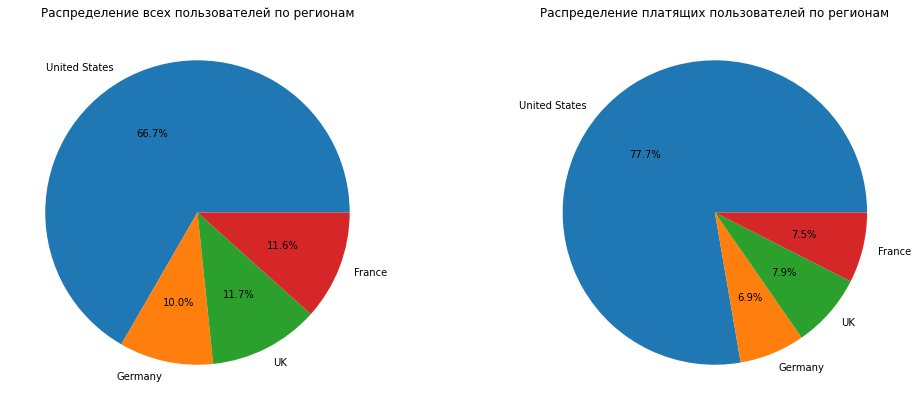

In [30]:
country = country.drop(index='total', axis=0)
country = country.reset_index()
fig, ax = plt.subplots(1, 2, figsize = (17, 7),  squeeze=False)
ax[0][1].pie(country.payer, labels=country.region, autopct='%1.1f%%')
ax[0][1].set(title='Распределение платящих пользователей по регионам')
ax[0][0].pie(country.all_users, labels=country.region, autopct='%1.1f%%')
ax[0][0].set(title='Распределение всех пользователей по регионам')
plt.show()

**Вывод:** Абсолютным фаворитом по привлечённым пользователям является США(около 100 000). Лидером по количеству(6902) и по доле(6.9%) платящих пользователей является США.

#### Изучим, какими устройствами чаще всего обладают пользователи

In [31]:
device = pivot_df('device')

In [32]:
device.style.format({'payer_share': '%{:.1f}'})

payer,not_payer,payer,all_users,payer_share
device,,,,
Mac,28130,1912,30042,%6.4
iPhone,51097,3382,54479,%6.2
Android,32982,2050,35032,%5.9
PC,28918,1537,30455,%5.0
total,141127,8881,150008,%0.0


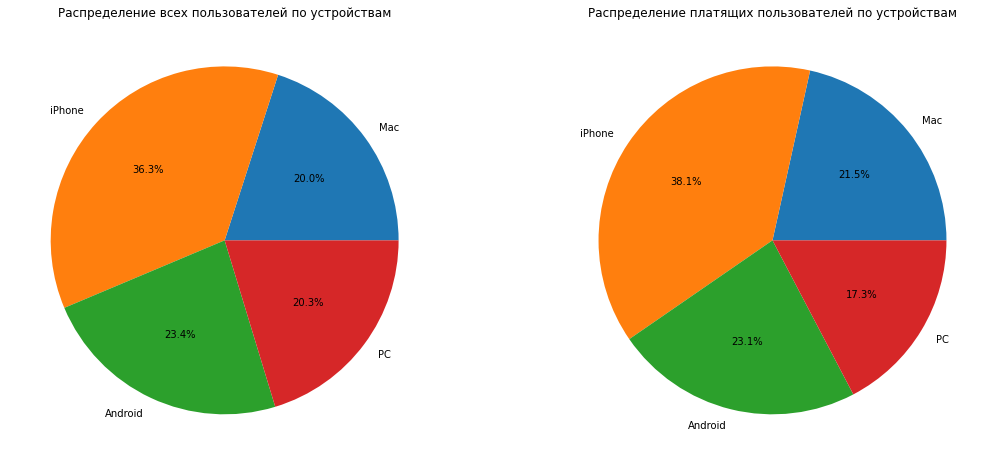

In [33]:
device = device.drop(index='total', axis=0)
device = device.reset_index()

fig, ax = plt.subplots(1, 2, figsize = (18, 8),  squeeze=False)
ax[0][1].pie(device.payer, labels=device.device, autopct='%1.1f%%')
ax[0][1].set(title='Распределение платящих пользователей по устройствам')
ax[0][0].pie(device.all_users, labels=device.device, autopct='%1.1f%%')
ax[0][0].set(title='Распределение всех пользователей по устройствам')
plt.show()

Для начала рассмотрим общую ситуацию по **всем** пользователям.

In [34]:
profiles_by_device = profiles.groupby('device').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
profiles_by_device['ratio'] = ((profiles_by_device['user_id']/(profiles_by_device['user_id'].sum())) * 100).round(2)
profiles_by_device.loc['total'] = profiles_by_device.sum(axis=0)
profiles_by_device

,user_id,ratio
device,,
iPhone,54479.0,36.32
Android,35032.0,23.35
PC,30455.0,20.30
Mac,30042.0,20.03
total,150008.0,100.00


По **платящим** пользователям

In [35]:
profiles_by_device_paid = profiles.query('payer == True')\
                                  .groupby('device').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
profiles_by_device_paid['ratio'] = ((profiles_by_device_paid['user_id']/(profiles_by_device_paid['user_id'].sum())) * 100).round(2)
profiles_by_device_paid.loc['total'] = profiles_by_device_paid.sum(axis=0)
profiles_by_device_paid

,user_id,ratio
device,,
iPhone,3382.0,38.08
Android,2050.0,23.08
Mac,1912.0,21.53
PC,1537.0,17.31
total,8881.0,100.00


По **неплатящим** пользователям

In [36]:
profiles_by_device_free = profiles.query('payer == False')\
                                  .groupby('device').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
profiles_by_device_free['ratio'] = ((profiles_by_device_free['user_id']/(profiles_by_device_free['user_id'].sum())) * 100).round(2)
profiles_by_device_free.loc['total'] = profiles_by_device_free.sum(axis=0)
profiles_by_device_free

,user_id,ratio
device,,
iPhone,51097.0,36.21
Android,32982.0,23.37
PC,28918.0,20.49
Mac,28130.0,19.93
total,141127.0,100.00


**Вывод:** чаще всего пользователи пользуются мобильными устройствами - в 36-38% случаев Iphone, примерно в 23% случаев Android.\
При этом наибольшая доля платящих пользователей представлена среди пользователей Mac(6.4%) и Iphone(6.2%). Реже всего(в 5 % случаев) представлен PC среди платящих пользователей.

#### Посмотрим, из каких источников пользователи переходят в приложение

In [37]:
channel = pivot_df('channel')

In [38]:
channel.style.format({'payer_share': '%{:.1f}'})

payer,not_payer,payer,all_users,payer_share
channel,,,,
FaceBoom,25587,3557,29144,%12.2
AdNonSense,3440,440,3880,%11.3
lambdaMediaAds,1924,225,2149,%10.5
TipTop,17683,1878,19561,%9.6
RocketSuperAds,4096,352,4448,%7.9
WahooNetBanner,8100,453,8553,%5.3
YRabbit,4147,165,4312,%3.8
MediaTornado,4208,156,4364,%3.6
LeapBob,8291,262,8553,%3.1


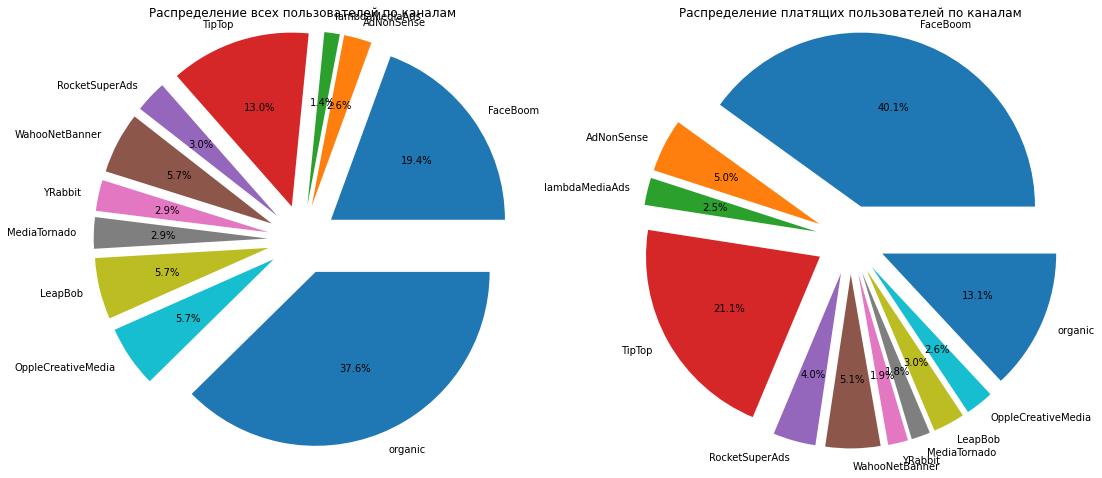

In [39]:
channel = channel.drop(index='total', axis=0)
channel = channel.reset_index()
explode = (0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2)
fig, ax = plt.subplots(1, 2, figsize = (18, 8),  squeeze=False)
ax[0][1].pie(channel.payer, labels=channel.channel, autopct='%1.1f%%', explode=explode)
ax[0][1].set(title='Распределение платящих пользователей по каналам')
ax[0][0].pie(channel.all_users, labels=channel.channel, autopct='%1.1f%%', explode = explode)
ax[0][0].set(title='Распределение всех пользователей по каналам')
plt.show()

#### Посмотрим, как зависят каналы привлечения от страны

In [40]:
regions_by_channels = (
    profiles[profiles['payer']==True].pivot_table(index='channel', 
                                              columns = 'region', 
                                              values = 'user_id', 
                                              aggfunc='count')
    .reset_index()
    .sort_values('United States')
    .query('channel != "organic"')
)
regions_by_channels

region,channel,France,Germany,UK,United States
3,MediaTornado,NaN,NaN,NaN,156.0
8,YRabbit,NaN,NaN,NaN,165.0
5,RocketSuperAds,NaN,NaN,NaN,352.0
6,TipTop,NaN,NaN,NaN,1878.0
1,FaceBoom,NaN,NaN,NaN,3557.0
0,AdNonSense,150.0,142.0,148.0,NaN
2,LeapBob,90.0,69.0,103.0,NaN
4,OppleCreativeMedia,80.0,64.0,89.0,NaN
7,WahooNetBanner,152.0,148.0,153.0,NaN
9,lambdaMediaAds,82.0,67.0,76.0,NaN


Таким образом, для США и Европы характерны собственные уникальные каналы привлечения клиентов. Создадим дополнительные датафреймы, разделив каналы по регионам

In [41]:
usa_channels = regions_by_channels.loc[regions_by_channels['United States'] > 0,'channel']
eu_channels = regions_by_channels.loc[regions_by_channels['France'] > 0,'channel']

**Выведём долю покупателей по каналам в США**

In [42]:
channel.query('channel in @usa_channels')\
       .sort_values(by='payer_share', ascending=False).style.format({'payer_share': '%{:.1f}'})

payer,channel,not_payer,payer,all_users,payer_share
0,FaceBoom,25587,3557,29144,%12.2
3,TipTop,17683,1878,19561,%9.6
4,RocketSuperAds,4096,352,4448,%7.9
6,YRabbit,4147,165,4312,%3.8
7,MediaTornado,4208,156,4364,%3.6


**Выведём долю покупателей по каналам в Европе**

In [43]:
channel.query('channel in @eu_channels')\
       .sort_values(by='payer_share', ascending=False).style.format({'payer_share': '%{:.1f}'})

payer,channel,not_payer,payer,all_users,payer_share
1,AdNonSense,3440,440,3880,%11.3
2,lambdaMediaAds,1924,225,2149,%10.5
5,WahooNetBanner,8100,453,8553,%5.3
8,LeapBob,8291,262,8553,%3.1
9,OppleCreativeMedia,8372,233,8605,%2.7


**Вывод:** исходя  из анализа, больше всего платящих пользователей приходит черед FaceBoom (12%) и AdNonSense(11.3%).\
Всего пользователей больше прочего приходит через канал organic - 55279 чел. При этом доля платящих среди них наименьшая - около 2%.\
При это для США и стран Европы характерны различные уникальные для регионов каналы.\
Среди площадок американского рынка максимальное количество покупателей привлекают площадки FaceBoom и TipTop - подавляющее количество покупателей из США пришли именно оттуда. В Европе наиболее популярны adnonsense и lambdamediaads.

**Промежуточный вывод:**
1) В анализе представлено 4 страны: США, Великобритания, Германия и Франция.\
2) БОльшая часть пользователей находится в США(более 65%), среди них и наибольшая доля платящих пользователей (6.9%).\
3) Чаще всего пользователи пользуются мобильными устройствами - в 36-38% случаев Iphone, примерно в 23% случаев Android.При этом наибольшая доля платящих пользователей представлена среди пользователей Mac(6.4%) и Iphone(6.2%). Реже всего(в 5 % случаев) представлен PC среди платящих пользователей.\
4) БОльшая часть пользователей приходит самостоятельно (около трети), среди привлечённых клиентов больше всего приходит через FaceBoom(12%) в США и AdNonSense(11.3%) в Европе. Для США И Европы характерны различные уникальные каналы привлечения 

### Маркетинг

#### Найдём общую сумму расходов

In [44]:
display(f"Общая сумма расходов равна {costs['costs'].sum().round(1)} рублей")

'Общая сумма расходов равна 105497.3 рублей'

In [45]:
cost_by_region = profiles.groupby('region')['acquisition_cost'].sum().sort_values(ascending=False)
cost_by_region.loc['total'] = cost_by_region.sum()
cost_by_region = cost_by_region.round(1).reset_index()
cost_by_region['ratio'] = ((cost_by_region['acquisition_cost']/105497.3) * 100).round(1)
cost_by_region.style.format({'ratio': '%{:.1f}', 'acquisition_cost': '{:.1f}'})

,region,acquisition_cost,ratio
0,United States,90928.6,%86.2
1,France,5076.0,%4.8
2,UK,5068.5,%4.8
3,Germany,4424.2,%4.2
4,total,105497.3,%100.0


**Большая часть средств на рекламу потрачена в США 90 928.6 у.е (86.2%), в Европе потрачено 14 568.7 у.е (14.8%)**

#### Выясним, как потрачены средства на различные источники

In [46]:
costs_by_channel = costs.groupby('channel')['costs'].sum().sort_values(ascending=False).reset_index()
costs_by_channel['%'] = (costs_by_channel['costs']/costs_by_channel['costs'].sum() * 100).round(1)
costs_by_channel.style.format({'%': '%{:.1f}', 'costs': '{:.1f}'})

,channel,costs,%
0,TipTop,54751.3,%51.9
1,FaceBoom,32445.6,%30.8
2,WahooNetBanner,5151.0,%4.9
3,AdNonSense,3911.2,%3.7
4,OppleCreativeMedia,2151.2,%2.0
5,RocketSuperAds,1833.0,%1.7
6,LeapBob,1797.6,%1.7
7,lambdaMediaAds,1557.6,%1.5
8,MediaTornado,954.5,%0.9
9,YRabbit,944.2,%0.9


**Вывод:** больше всего средств потратили на TipTop(около 52% от всех затрат) и FaceBoom(около 31 % от всех затрат). Эти два канала занимают более 80% от суммы всех затрат. Меньше всего потрачено на YRabbit и MediaTornado(менее 1 % на каждый).

#### Динамика изменения расходов по неделям и месяцам

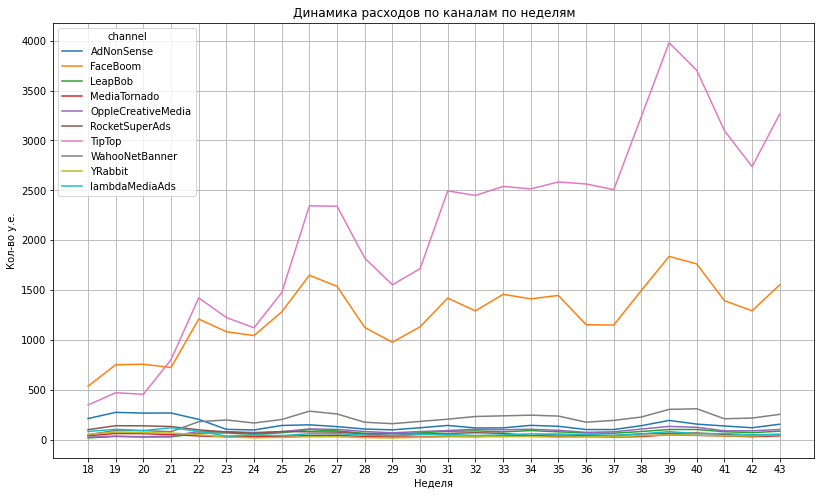

In [47]:
costs.dt = pd.to_datetime(costs.dt)
costs['week'] = costs.dt.dt.isocalendar().week
costs['month'] = costs.dt.dt.month

weekly_costs = costs.pivot_table(index='channel', columns='week', values='costs', aggfunc='sum')
weekly_costs.T.plot(grid=True, xticks=list(weekly_costs.columns.values), ax=plt.subplot(1, 2, 1), figsize=(30,8))
plt.title('Динамика расходов по каналам по неделям')
plt.xlabel('Неделя')
plt.ylabel('Кол-во у.е.')
plt.show()

Динамика затрат по неделям без учёта TipTop и FaceBoom

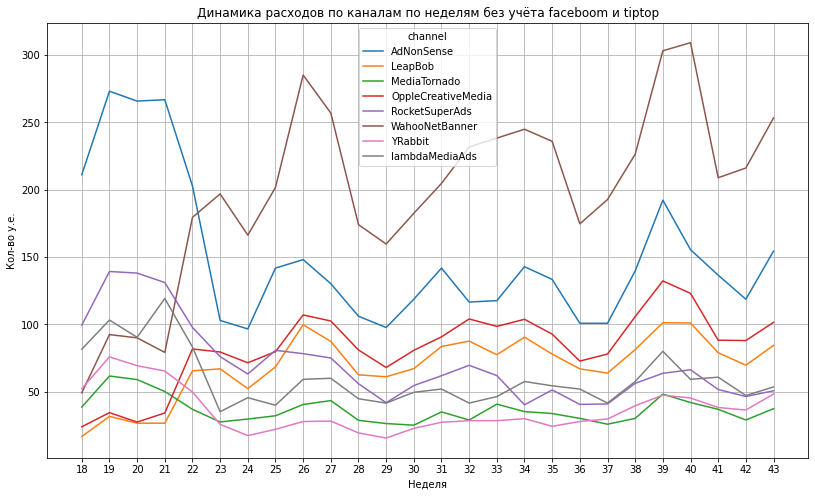

In [48]:
weekly_costs.query('channel != ["TipTop", "FaceBoom"]')\
.T.plot(grid=True, xticks=list(weekly_costs.columns.values), ax=plt.subplot(1, 2, 1), figsize=(30,8))
plt.title('Динамика расходов по каналам по неделям без учёта faceboom и tiptop')
plt.xlabel('Неделя')
plt.ylabel('Кол-во у.е.')
plt.show()

По графику больше прочих выделяется динамика изменения расходов на каналы TipTop и FaceBoom. Если в начале исследуемого периода затраты на tiptop были меньше, чем на faceboom, то к концу периода расходы на tiptop стали более, чем в 2 раза выше расходов на faceboom.\
Линии динамики изменений расходов на каналы tiptop и faceboom похожи, они, в целом, описывают подход к расходам в течение всего периода. Исключением здесь является период с 35 по 37 недели, где со снижением затрат на Faceboom растут затраты на tiptop.\
Среди остальных источников рекламный бюджет увеличился только у WahooNetBanner. Затраты на остальные каналы либо почти не изменились, либо снизились.\
Пик расходов наблюдается на 39 неделе.

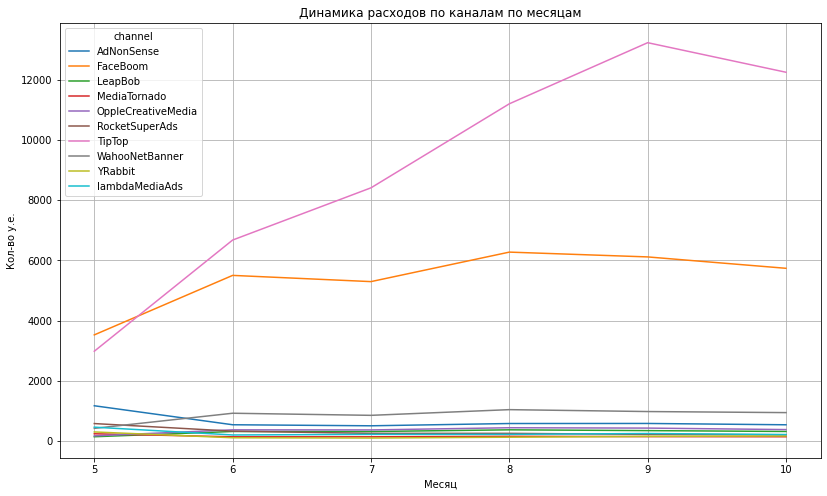

In [49]:
monthly_costs = costs.pivot_table(index='channel', columns='month', values='costs', aggfunc='sum')
monthly_costs.T.plot(grid=True, xticks=list(monthly_costs.columns.values), ax=plt.subplot(1, 2, 1), figsize=(30,8))
plt.title('Динамика расходов по каналам по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Кол-во у.е.')
plt.show()

Динамика затрат по месяцам без учёта TipTop и FaceBoom

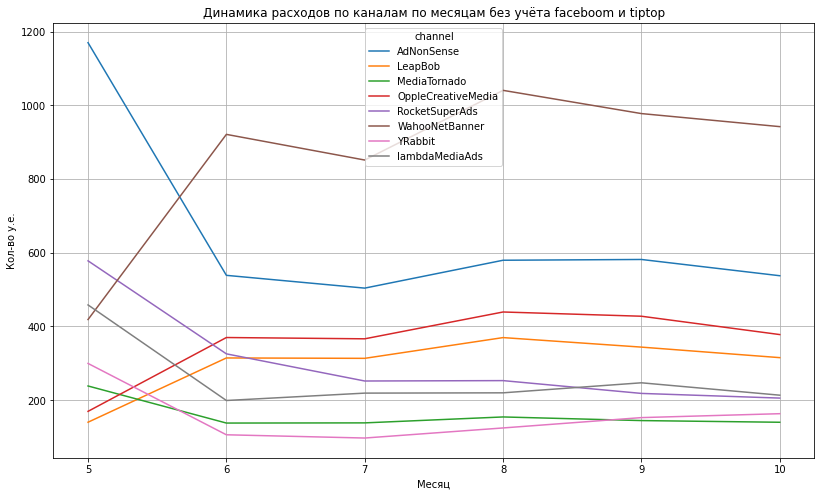

In [50]:
monthly_costs.query('channel != ["TipTop", "FaceBoom"]')\
.T.plot(grid=True, xticks=list(monthly_costs.columns.values), ax=plt.subplot(1, 2, 1), figsize=(30,8))
plt.title('Динамика расходов по каналам по месяцам без учёта faceboom и tiptop')
plt.xlabel('Месяц')
plt.ylabel('Кол-во у.е.')
plt.show()

По месяцам наблюдается схожая с динамикой по неделям ситуация. Основными статьями расходов здесь являются затраты на Faceboom и tiptop.\
Пик расходов наблюдается в 9 месяце.

**Вывод:**
- наиболее затратные каналы - tiptop, faceboom, при этом расходы на tiptop на конец периода более, чем в два раза выше расходов на faceboom;
- рекламный бюджет увеличился на следующие каналы: tiptop, faceboom, wahoonetbanner, opplecreativemedia, и leapbop, затраты на остальные каналы снизились;
- больше всего затраты выросли на tiptop;
- пик расходов представлен в 9 месяце на 39 неделе (сентябрь).

#### Средняя стоимость привлечения 1 пользователя CAC

In [51]:
cac_data = profiles.query('channel != "organic"')\
.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')\
.sort_values(by='acquisition_cost', ascending=False).rename(columns={'acquisition_cost':'cac'})
cac_data['cac'] = cac_data['cac'].round(1)
cac_data.style.format({'cac': '{:.1f} у.е.'})

,cac
channel,
TipTop,2.8 у.е.
FaceBoom,1.1 у.е.
AdNonSense,1.0 у.е.
lambdaMediaAds,0.7 у.е.
WahooNetBanner,0.6 у.е.
RocketSuperAds,0.4 у.е.
OppleCreativeMedia,0.2 у.е.
YRabbit,0.2 у.е.
MediaTornado,0.2 у.е.


Наибольший показатель CAC представлен в TipTop (2.8 у.е), далее следуют faceboom и adnonsense с примерно равной стоимостью - 1.1 и 1 у.е. соответственно. Наименее затратные каналы - leapbop, mediatornado, yrabbit, opplecreativemedia (0.2 у.е.).

**Промежуточный вывод:**
- всего на маркетинг потрачено 105 497,3 у.е., из которых более 86% потрачено в США;
- больше всего средств потратили на TipTop(около 52% от всех затрат) и FaceBoom(около 31 % от всех затрат), меньше всего потрачено на YRabbit и MediaTornado(менее 1 % на каждый);
- наиболее затратные каналы - tiptop, faceboom, при этом расходы на tiptop на конец периода более, чем в два раза выше расходов на faceboom;
- рекламный бюджет увеличился на следующие каналы: tiptop, faceboom, wahoonetbanner, opplecreativemedia, и leapbop, затраты на остальные каналы снизились, больше всего затраты выросли на tiptop;
- пик расходов представлен в 9 месяце на 39 неделе (сентябрь);
- наибольший показатель CAC представлен в TipTop (2.8 у.е), далее следуют faceboom и adnonsense с примерно равной стоимостью - 1.1 и 1 у.е. соответственно. Наименее затратные каналы - leapbop, mediatornado, yrabbit, opplecreativemedia (0.2 у.е.).

### Оценка окупаемости рекламы

Исходя из условия установим следующие показатели момента и горизонта анализа:

In [52]:
observation_date = datetime(2019, 10, 27).date()  # момент анализа
horizon_days = 14  # горизонт анализа

Уберём из анализа канал organic для того, чтобы он не искажал ситуацию, к тому же, он по своей сути бесплатен.

In [53]:
profiles = profiles.query('channel != "organic"')

#### Сперва оценим общую ситуацию с окупаемостью рекламы

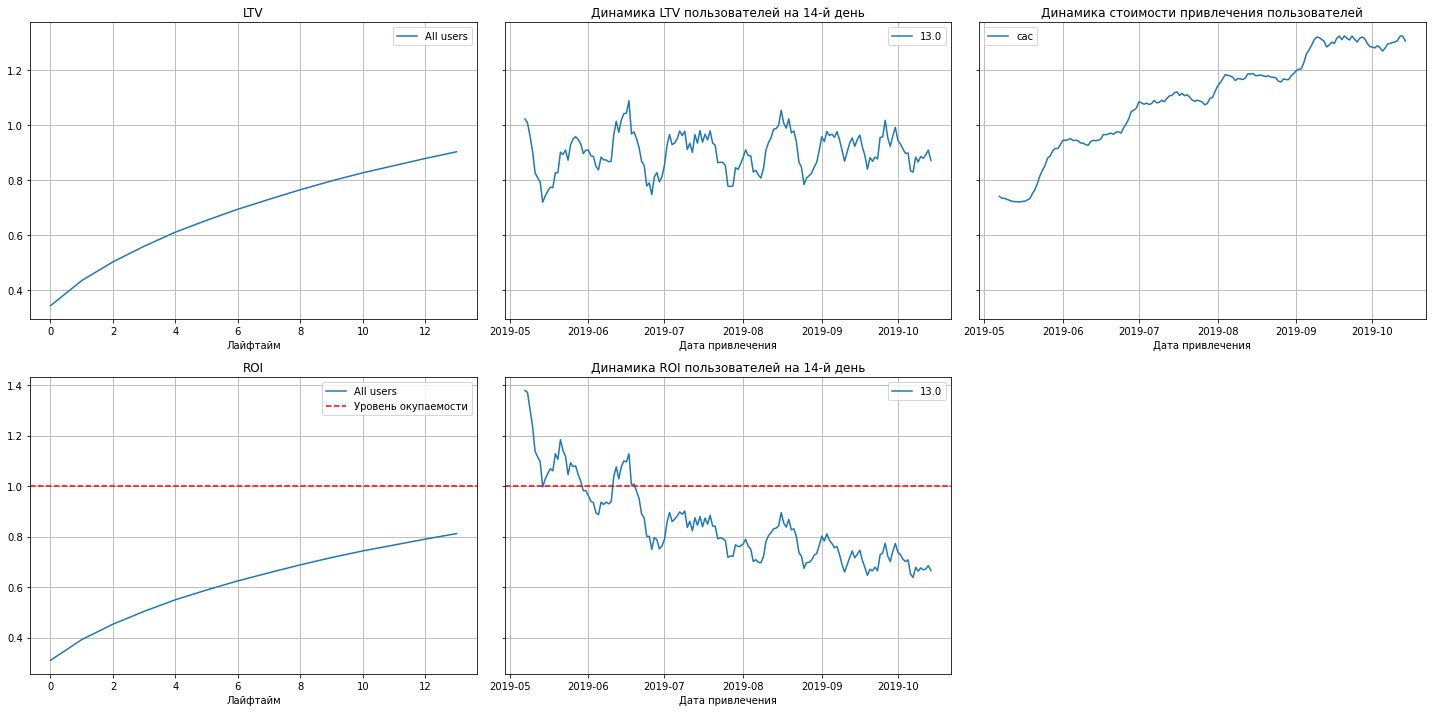

In [54]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

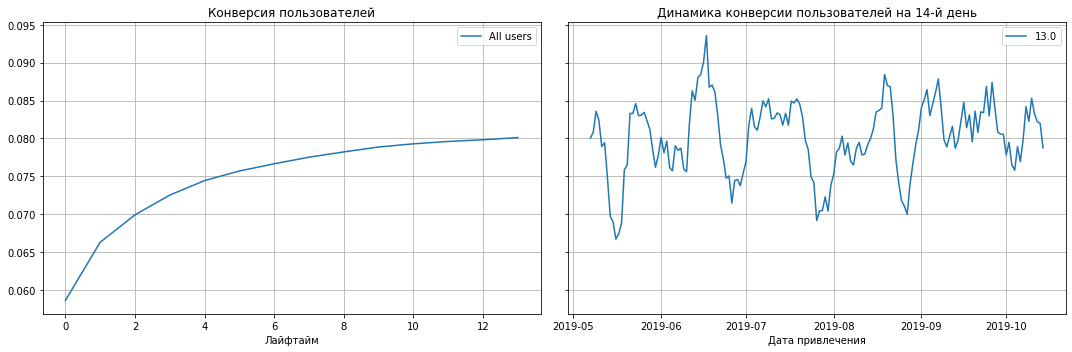

In [55]:
# смотрим конверсию с разбивкой по устройствам
dimensions = []
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

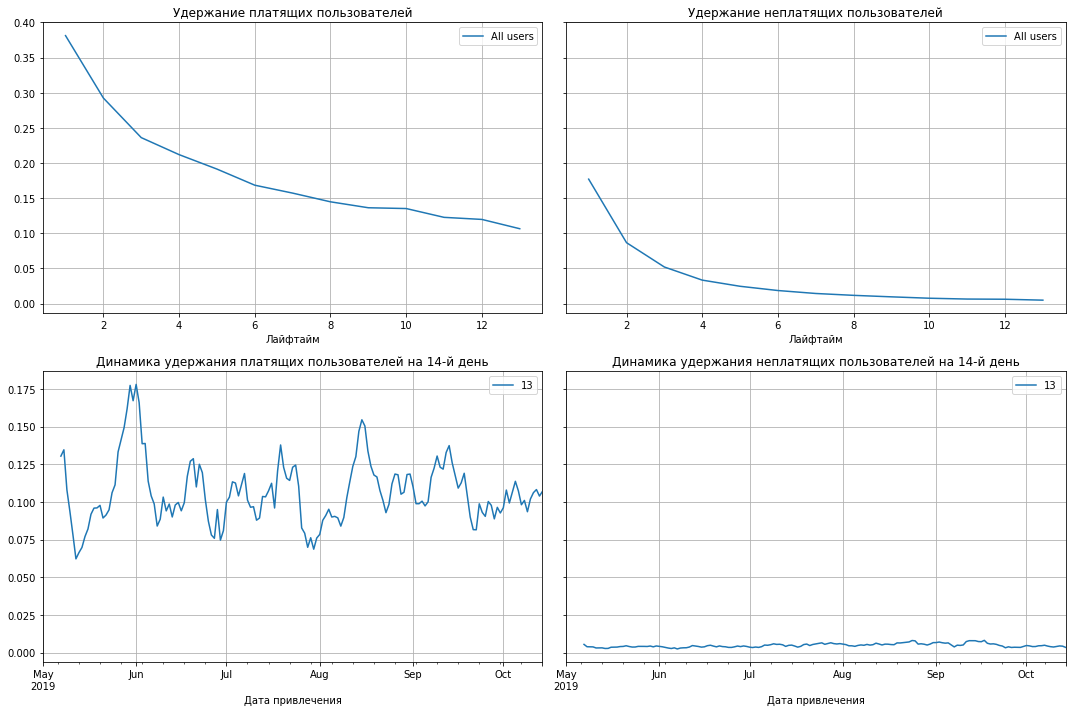

In [56]:
# смотрим удержание с разбивкой по устройствам
dimensions = []
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Выводы:**
- реклама не окупается, ROI едва ли приблизился к 80% к концу лайфтайма;
- LTV достаточно стабилен;
- заметно выросла стоимость привлечения клиентов

#### Рассмотрим окупаемость по устройствам

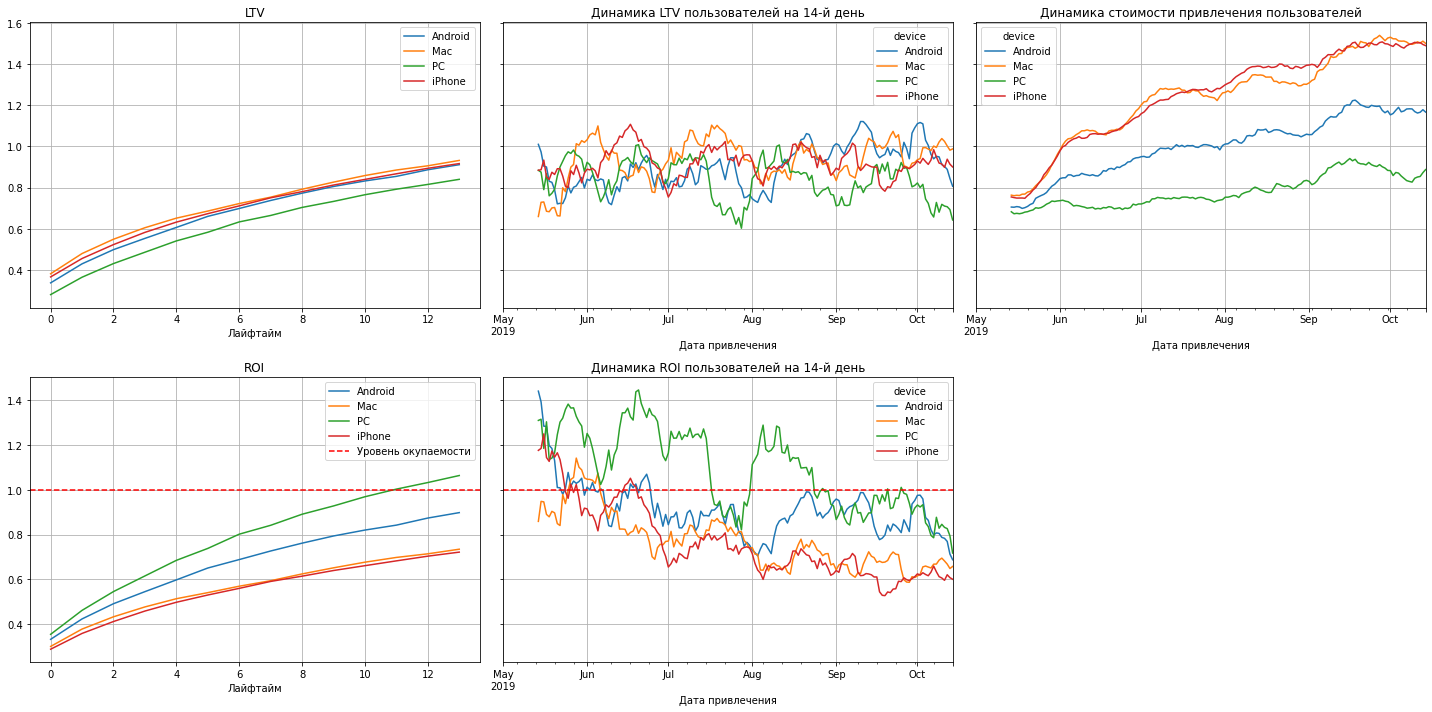

In [57]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

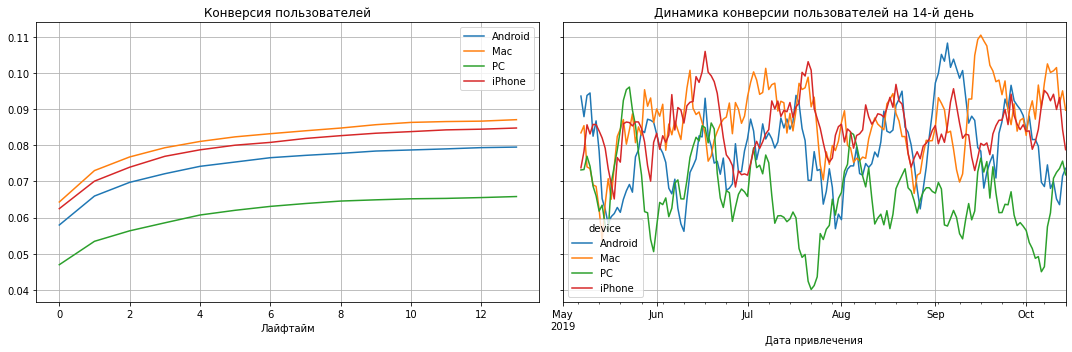

In [58]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

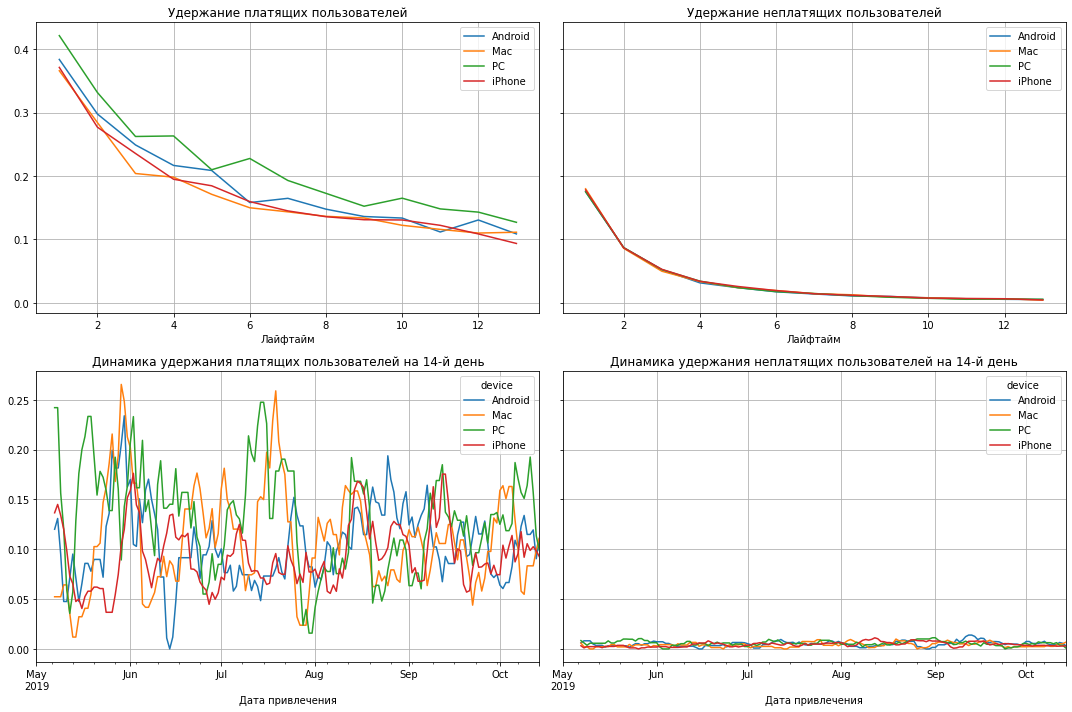

In [59]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**
- LTV по девайсам стабильно растёт;
- заметно растут траты на привлечение пользователей на всех девайсах(CAC), кроме PC;
- к 14-му дню реклама окупается только на PC;
- хуже всех конвертируются пользователи PC, при этом удерживаются они лучше остальных.

#### Рассмотрим окупаемость по странам

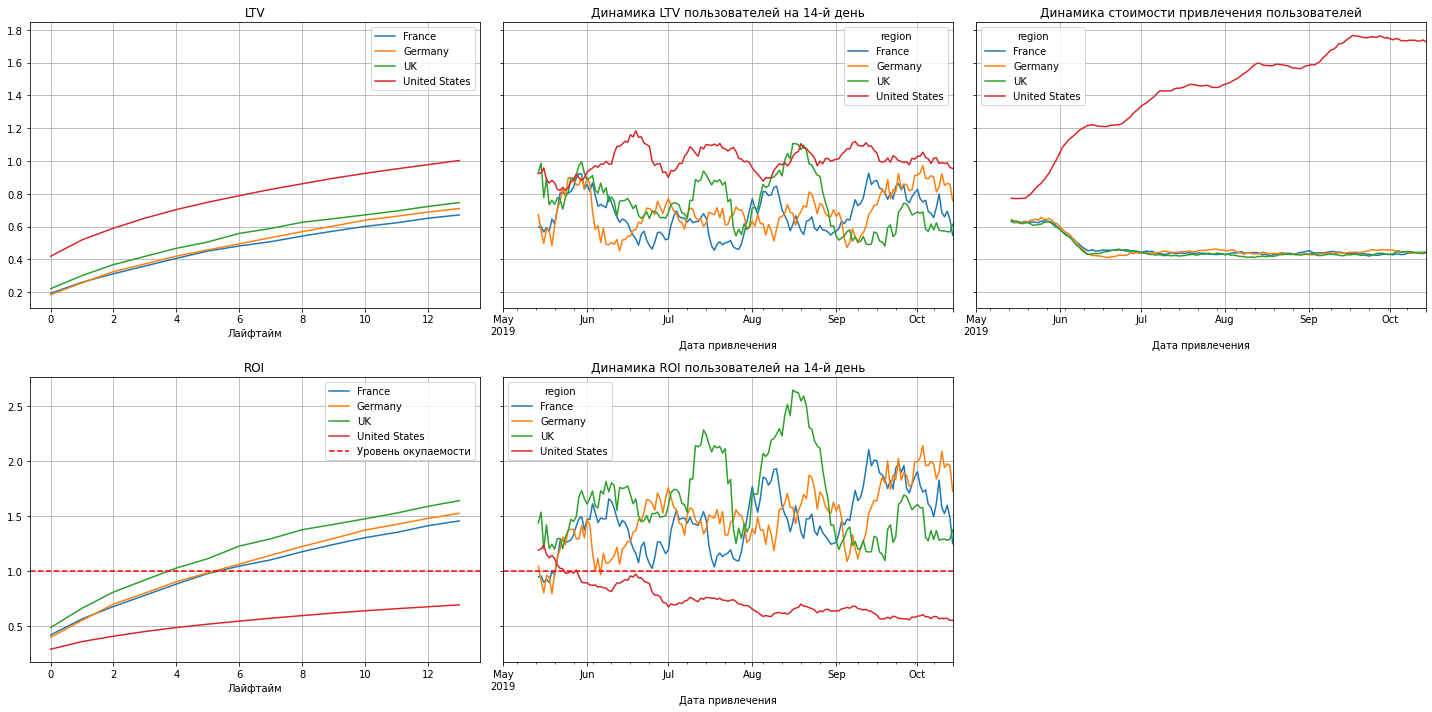

In [60]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

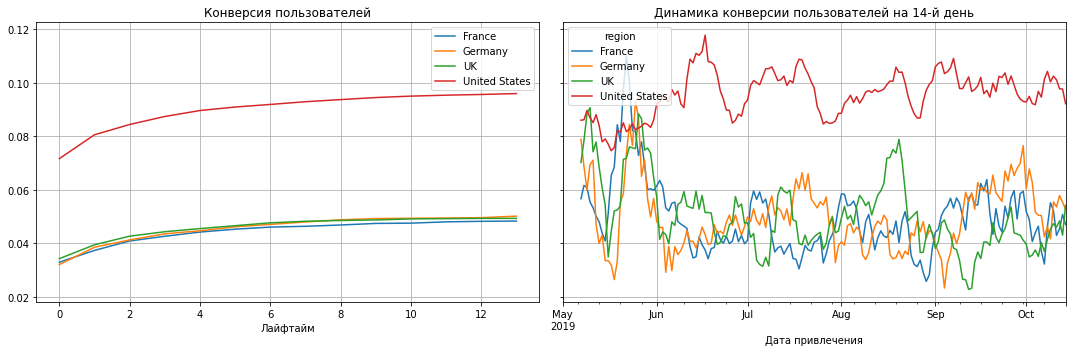

In [61]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Стоит отметить проседание конверсии в европейских странах после мая 2019 года. Возможно, это связано с тем, что в преддверии летней поры развлекательное приложение мало кому нужно.

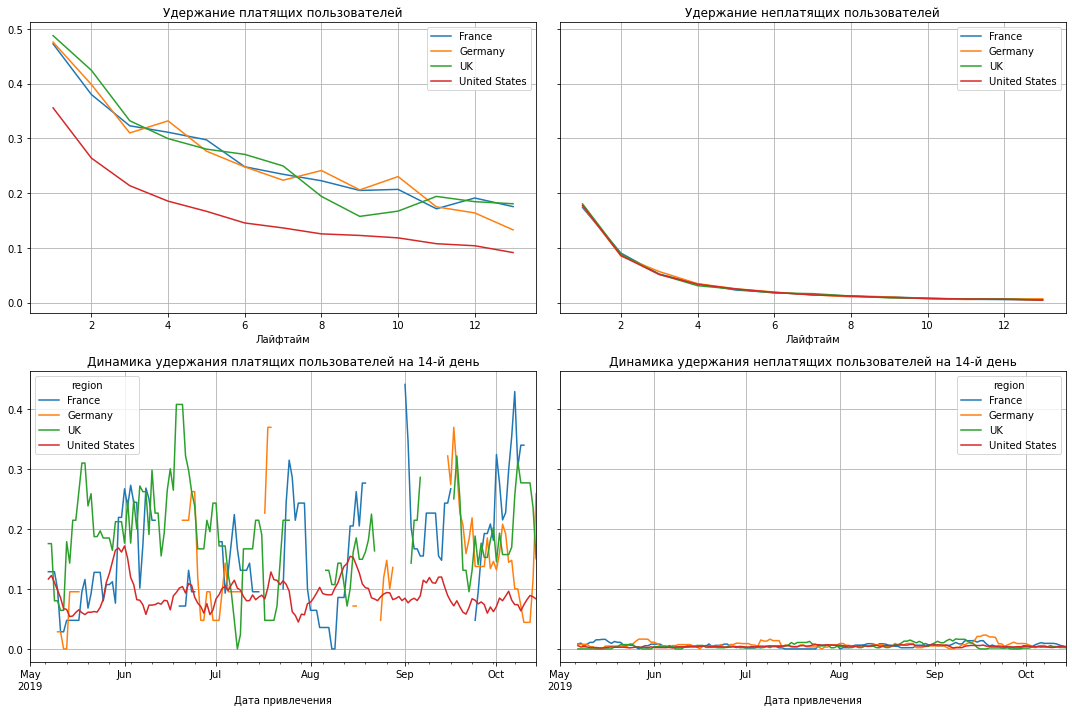

In [62]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**
- LTV в разбивке по странам растёт;
- в США заметно выросла стоимость привлечения клиентов, в остальных странах она снизилась
- реклама в Германии, Франции и Великобритании по графику ROI окупается, зато в США не окупается, график динамики ROI показывает ту же ситуацию;
- лучше всего конвертируются пользователи из США, при этом удерживаются они хуже прочих.

#### Рассмотрим окупаемость по каналам

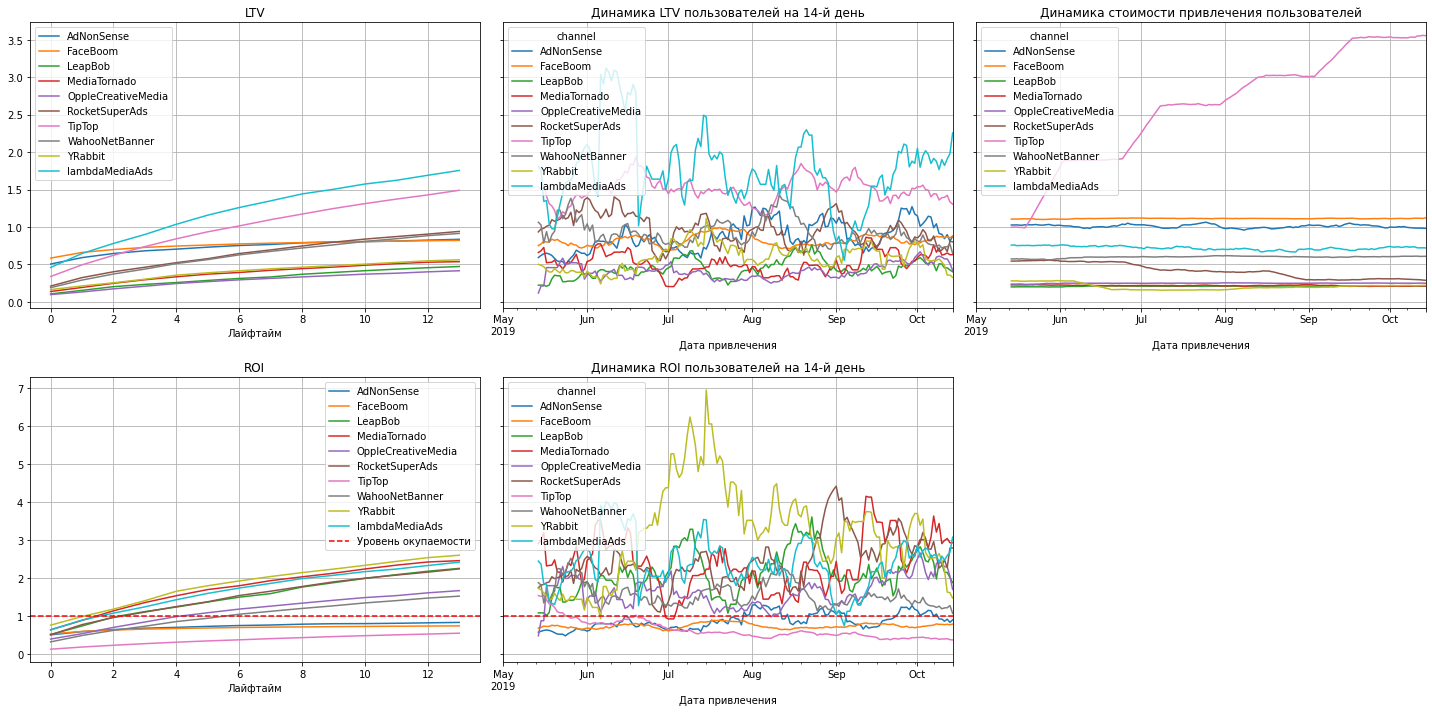

In [63]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

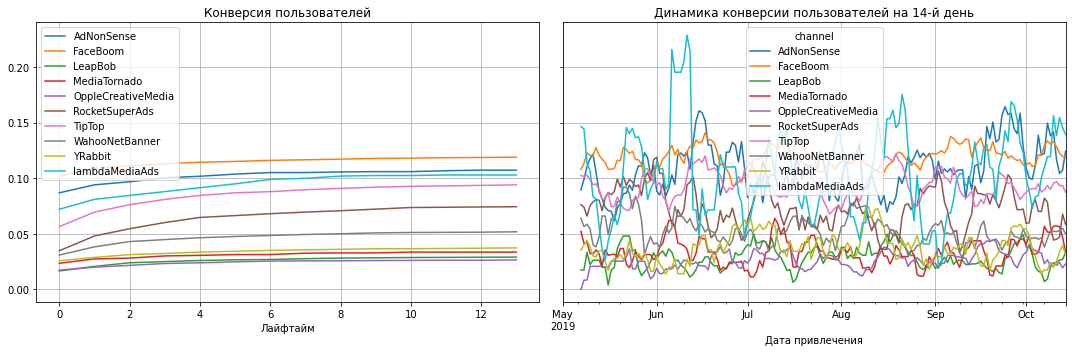

In [64]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

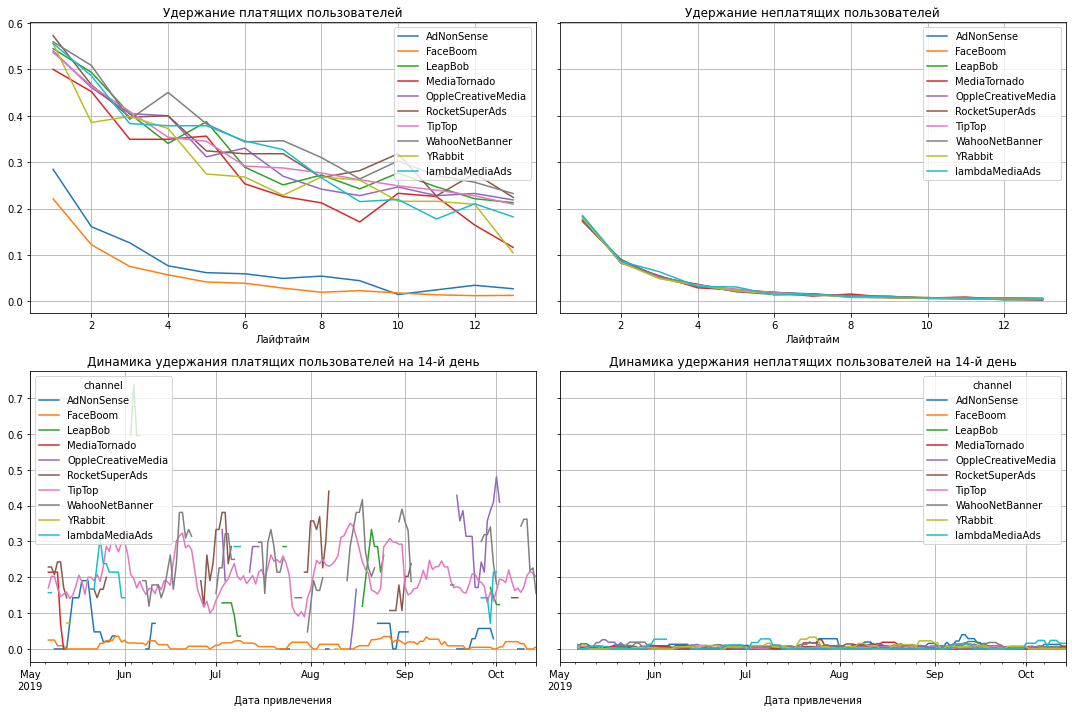

In [65]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Посмотрим на эффективность рекламных кампаний в США**

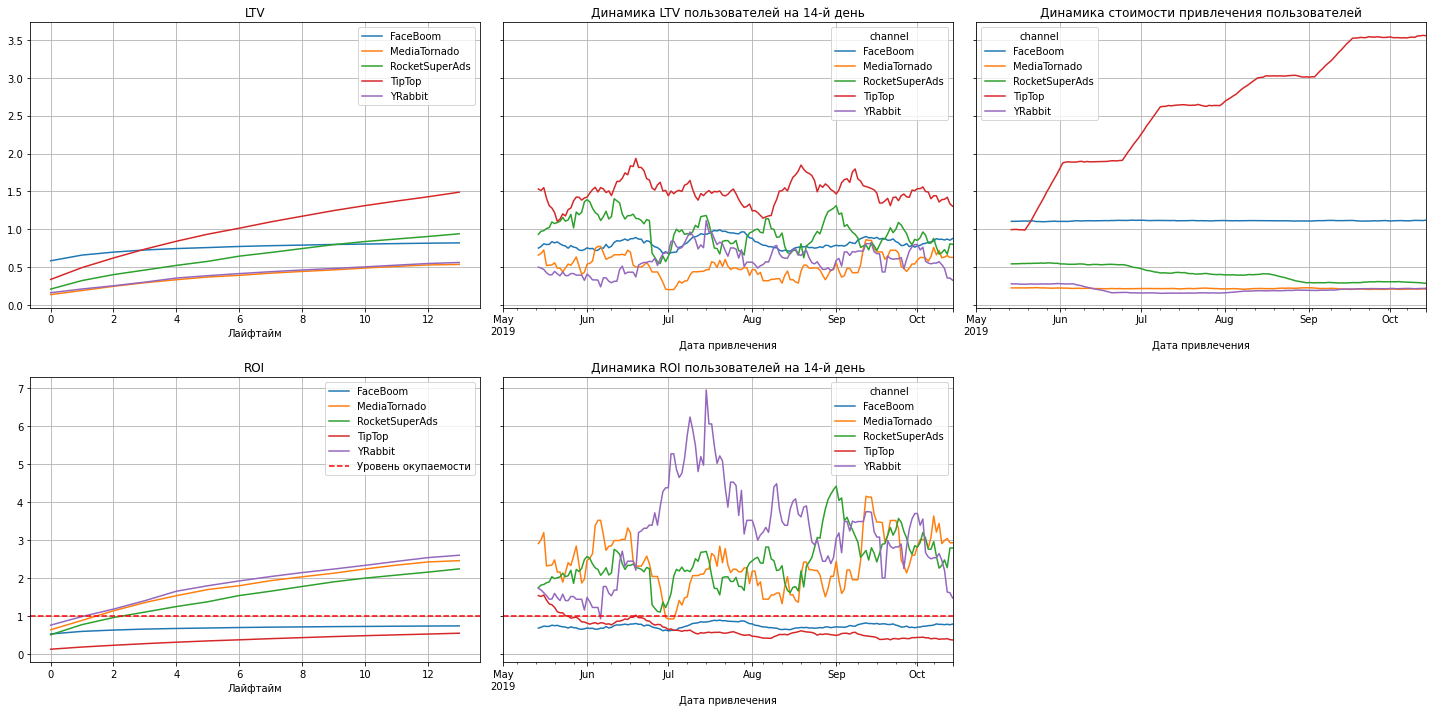

In [66]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel in @usa_channels'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

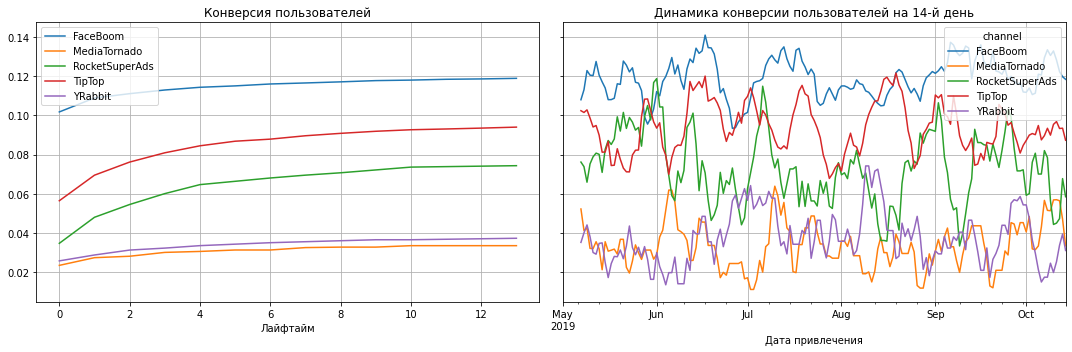

In [67]:
# смотрим конверсию с разбивкой по каналам в США
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel in @usa_channels'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

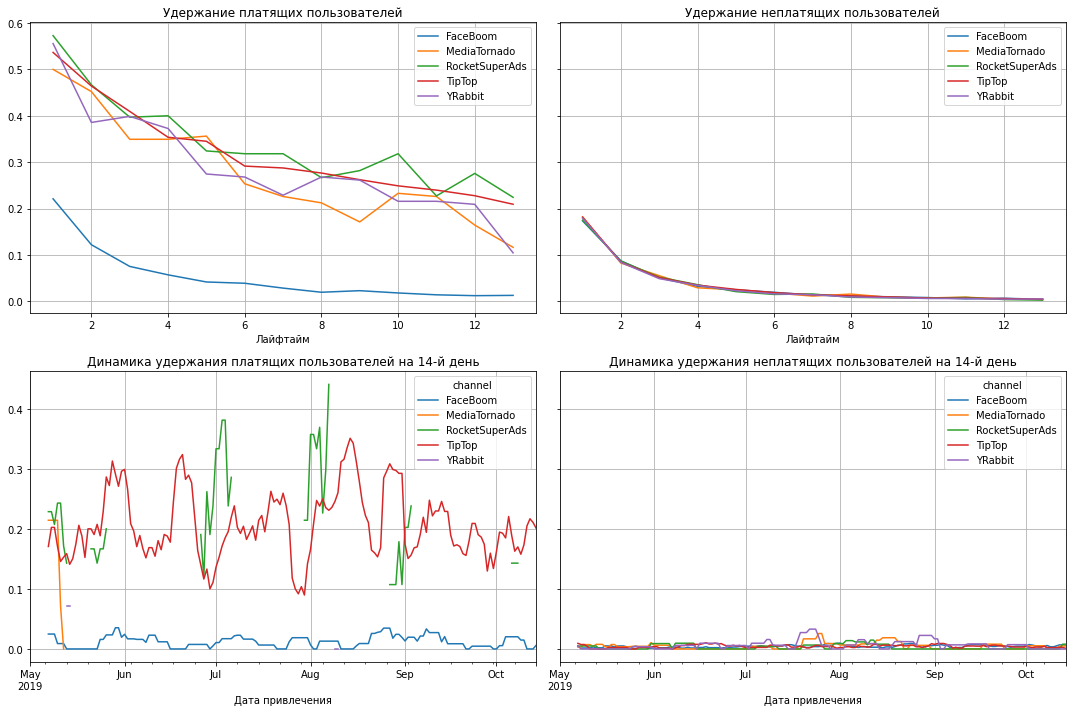

In [68]:
# смотрим удержание с разбивкой по каналам в США

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel in @usa_channels'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

В США не окупаются только faceboom и tiptop. Лучше прочих окупается YRabbit и MediaTornado.\
<font color='green'>Для faceboom характерен наименьший показатель удержания пользователей при том, что конверсия у него наивысшая. Динамика удержания пользователей у FaceBoom почти такая же, как у неплатящих пользователей</font>

**Посмотрим на эффективность рекламных кампаний в Европе**

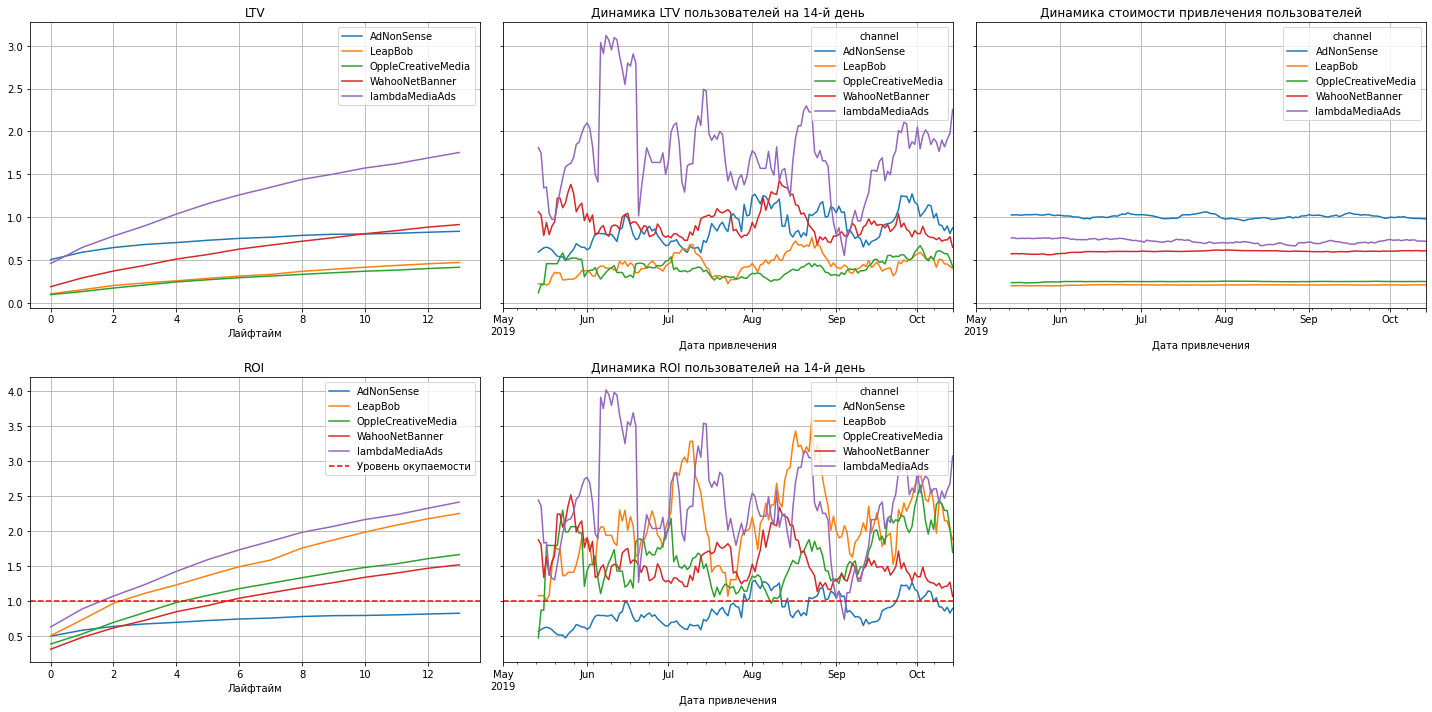

In [69]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel in @eu_channels'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

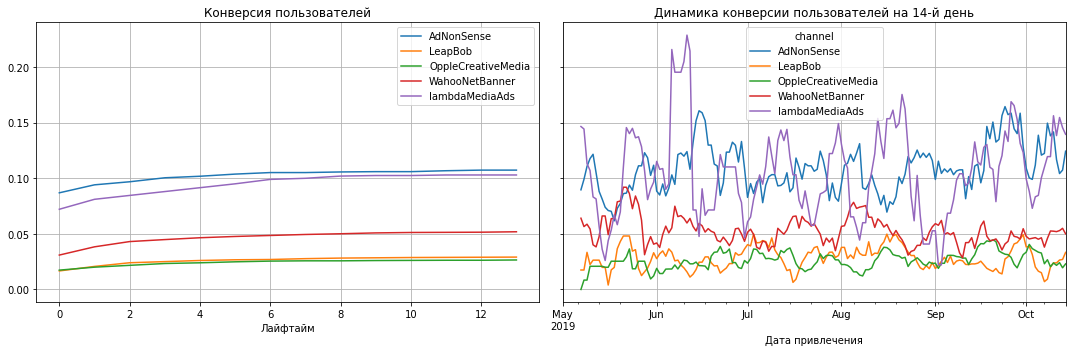

In [70]:
# смотрим конверсию с разбивкой по каналам в Европе
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel in @eu_channels'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

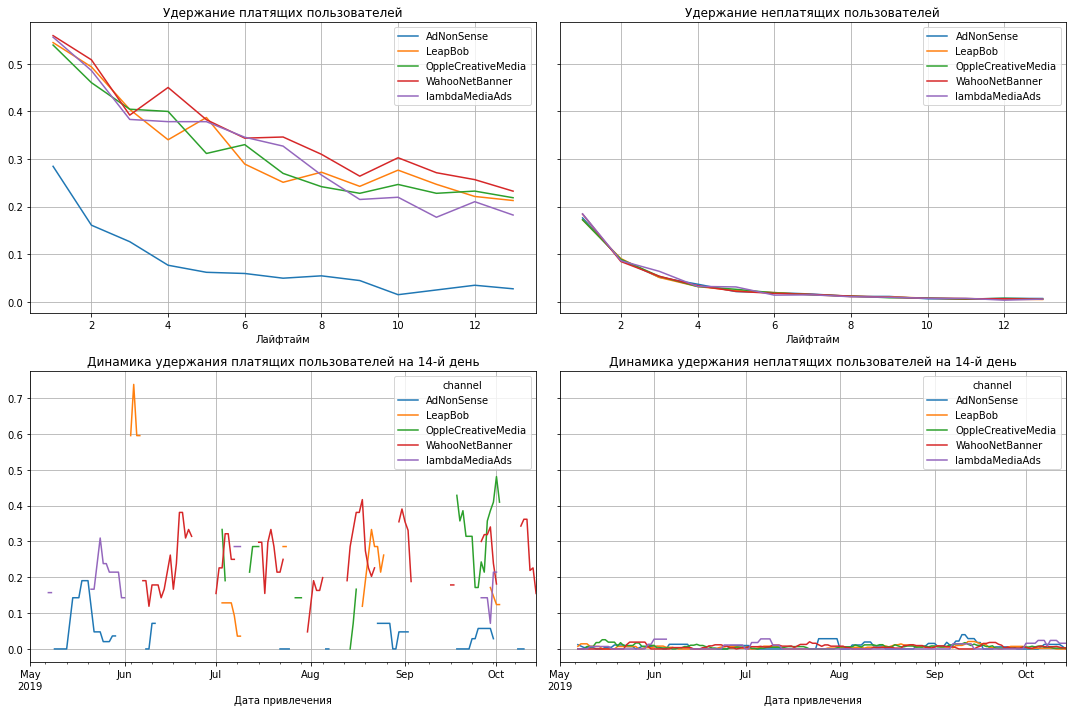

In [71]:
# смотрим удержание с разбивкой по каналам в Европе

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel in @eu_channels'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

В Европе не окупается только adnonsense. Лучше прочих окупается lambdaMediaAds. Любопытна ситуация с удержанием пользователей в Европе, удержание пользователей здесь весьма прерывисто.\
<font color='green'>
В Европе ситуация с удержанием такая же, как в США. Канал AdNonSense, на который тратится больше всего средств, имеет наихудший показать удержания пользователей при том, что конверсия у него наивысшая среди всех каналов.
</font>

**Вывод:**
- заметен внушительный рост показателя CAC для канала tiptop, при этом стоимость привлечения клиентов выросла только для этого канала;
- реклама не окупается на таких каналах, как adnonsense, faceboom и tiptop;
- конверсия почти не растёт;
- наибольшая конверсия характерна для каналов FaceBoom и adnonsense, при этом удерживаются они хуже всего.

**Промежуточный вывод:**
1) Реклама, в целом не окупается, ROI к концу 14-го дня не дотягивает до 80%.\
2) Основными факторами неокупаемости рекламы являются:
- низкая окупаемость рекламы в США, как в основном потребителе;
- стоит учесть, что при хорошем показателе конверсии в США, показатель удержания хуже, чем в остальных страна. Возможно пользователям не нравится функционал приложения; 
- нецелесообразные расходы на рекламу в tiptop, adnonsense и faceboom.
- среди устройств наихудший параметр конверсии замечен у PC, однако у него лучший показатель удержания и наименьшие затраты на привлечение клиентов.

### ОБЩИЙ ВЫВОД
1) Кол-во клиентов в США гораздо выше, чем во всех странах Европы вместе взятых и покупают в США чаще, чем в остальных странах, однако стоимость привлечения клиентов в США в 1.5 раза выше, чем в странах Европы.\
2) Основная причина убытков, вероятно, заключается в нецелесообразном маркетинге, при котором большАя часть средств направлена на рекламу в tiptop, faceboom и adnonsense. Реклама в этих каналах не окупается, к примеру, за исследуемый период реклама в tiptop выросла в 1.5 раза. Общая сумма расходов на tiptop и faceboom составляет более 80% (от 105 тыс. у.е.), а на tiptop было потрачено больше половины от рекламного бюджета. Стоит отметить, что пользователи faceboom и adnonsense при этом плохо удерживаются.\
3) Возможно, пользователям в США не нравится функционал приложения, поскольку показатель удержания очень низок в каналах(tiptop, faceboom), на которые направлены огромные денежные вложения и в которых велика конверсия пользователей. Либо же реклама настроена неэффективно и не попадает к целевой аудитории.

**Рекомендации:**
1) Пересмотреть рекламную политику, особенно в США. Вероятно, стоит снизить затраты на рекламу в Tiptop, Faceboom и AdNonSense и обратить внимание на другие каналы привлечения клиентов. Для США это YRabbit, MediaTornado. Для Европы - lambdaMediaAds. У них неплохая окупаемость и низкая стоимость привлечения клиентов. Например, показатель ROI у канала YRabbit составляет почти 300% при CAC, равном 0.2 у.е.\
2) Увеличить конверсию органических пользователей - их около 30% от всех пользователей, однако проценнт платящих среди них наименьший(около 2%).\
3) Удержание пользователей в европейских страна нестабильно. Присутствуют периоды, в которых кол-во пользователей проседает до нуля. Особенно это заметно в Германии. Вероятно, стоит увеличить расходы на рекламную кампанию в европейских странах, к тому же показатель CAC там даже снизился за рассматриваемый период, а все каналы привлечения покупателей окупаются, кроме adnonsense.